<a href="https://colab.research.google.com/github/Eadgnus/CatAndDog/blob/master/%EA%B0%95%EC%95%84%EC%A7%80_%EA%B3%A0%EC%96%91%EC%9D%B4_%EA%B5%AC%EB%B6%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'eadgnus'
os.environ['KAGGLE_KEY'] = 'd2ec4e5792f226155c96ef5d94643e9f'

In [ ]:
!kaggle competitions download -d dogs-vs-cats
!unzip -q dogs-vs-cats.zip

usage: kaggle
       [-h]
       [-v]
       {competitions,c,datasets,d,kernels,k,config}
       ...
kaggle: error: unrecognized arguments: -d
unzip:  cannot find or open dogs-vs-cats.zip, dogs-vs-cats.zip.zip or dogs-vs-cats.zip.ZIP.


In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip

--2023-06-20 04:11:56--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 142.250.99.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   212MB/s    in 0.3s    

2023-06-20 04:11:57 (212 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# 컴포즈는 여러개의 함수를 한번에 적용시켜줌
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),

        transforms.RandomAffine(0, scale=(0.8, 1.2)),
        # 좌우 반전
        transforms.RandomHorizontalFlip(),
        # 이미지를 텐서로 바꿔달라
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [ ]:
def target_transforms(target):
    return torch.FloatTensor([target])

In [ ]:
image_datasets = {
    'train': datasets.ImageFolder('cats_and_dogs_filtered/train', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('cats_and_dogs_filtered/validation', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

2000 1000


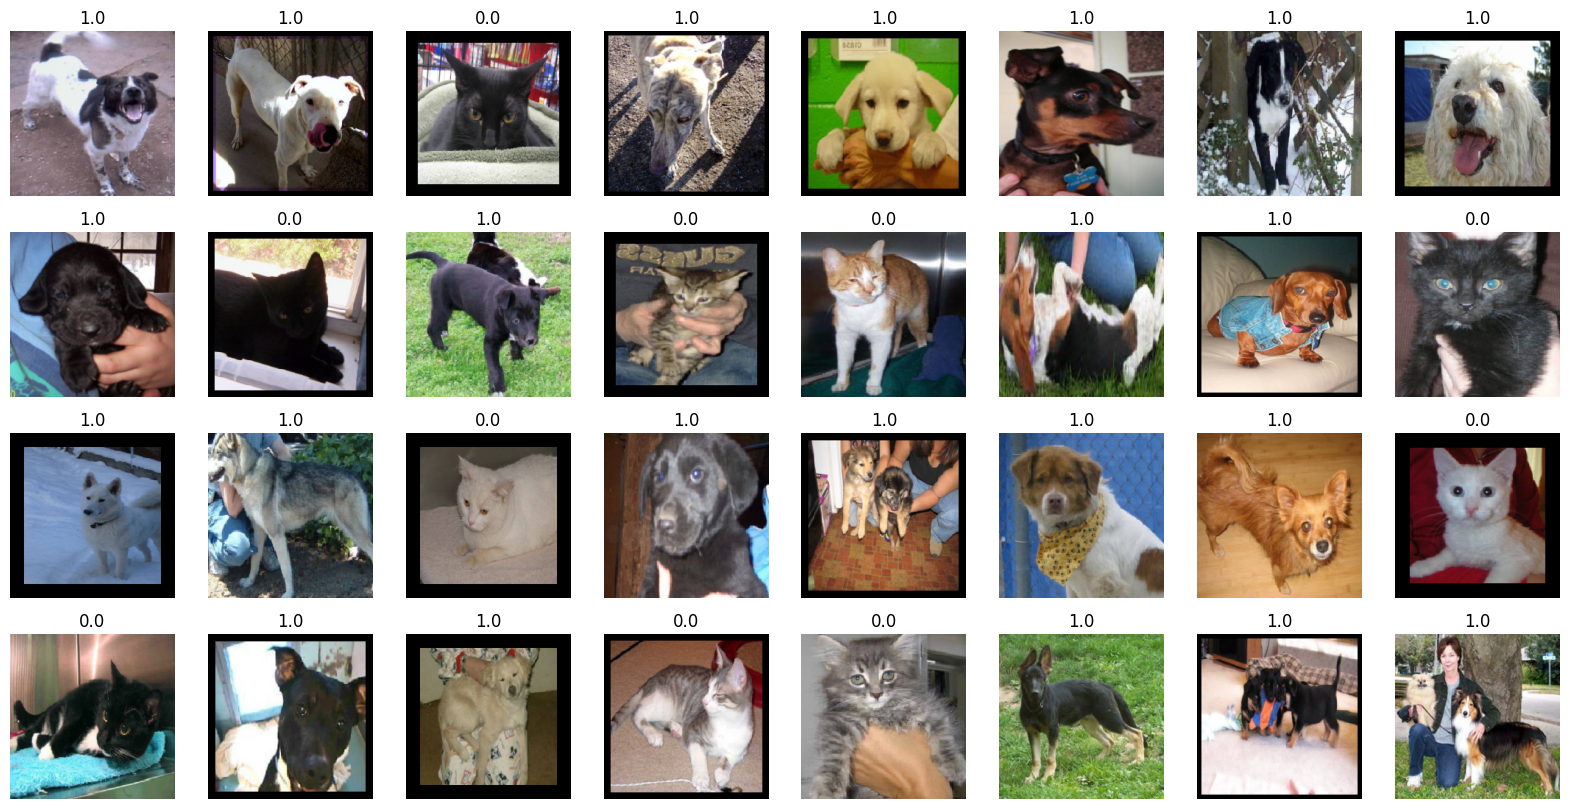

In [ ]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')

In [ ]:
# 미리 학습된 데이터를 가져오겠다.
# model = models.resnet50(pretrained=True).to(device)
model = models.resnet50(weights='IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 19.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for param in model.parameters():
    param.requires_grad = False # 가져온 파라미터(W, b)(웨이트, 바이어스)를 업데이트하지 않음

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 학습: fc 부분만 학습 함으로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            # 메모리에 옵티마이저를 돌리게 된다.
            model.train()
        else:
            # 옵티마이저 돌리는 메모리를 제거시키고 실제 테스트만 할수 있게 트레이닝에 사용한 데이터를 삭제 시킨다.
            model.eval()

        sum_losses = 0
        sum_accs = 0

        # phase에 train이나 validation이 들어감에 따라 학습, 테스트 모드
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses += loss.item()

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs += acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.1880, Accuracy: 93.30%
validation: Epoch    1/10, Loss: 0.0479, Accuracy: 98.44%
train     : Epoch    2/10, Loss: 0.1045, Accuracy: 96.28%
validation: Epoch    2/10, Loss: 0.0457, Accuracy: 98.24%
train     : Epoch    3/10, Loss: 0.0694, Accuracy: 97.17%
validation: Epoch    3/10, Loss: 0.0323, Accuracy: 98.83%
train     : Epoch    4/10, Loss: 0.0758, Accuracy: 96.88%
validation: Epoch    4/10, Loss: 0.0344, Accuracy: 98.93%
train     : Epoch    5/10, Loss: 0.0461, Accuracy: 98.12%
validation: Epoch    5/10, Loss: 0.0261, Accuracy: 99.12%
train     : Epoch    6/10, Loss: 0.1542, Accuracy: 94.35%
validation: Epoch    6/10, Loss: 0.0350, Accuracy: 98.83%
train     : Epoch    7/10, Loss: 0.0957, Accuracy: 96.18%
validation: Epoch    7/10, Loss: 0.0285, Accuracy: 98.93%
train     : Epoch    8/10, Loss: 0.0550, Accuracy: 97.77%
validation: Epoch    8/10, Loss: 0.0251, Accuracy: 99.22%
train     : Epoch    9/10, Loss: 0.0668, Accuracy: 97.32%
validation: Ep

In [ ]:
torch.save(model.state_dict(), 'model.h5')

In [ ]:
model = models.resnet50().to(device)

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

In [ ]:
# 학습: fc 부분만 학습 함으로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            # 메모리에 옵티마이저를 돌리게 된다.
            model.train()
        else:
            # 옵티마이저 돌리는 메모리를 제거시키고 실제 테스트만 할수 있게 트레이닝에 사용한 데이터를 삭제 시킨다.
            model.eval()

        sum_losses = 0
        sum_accs = 0

        # phase에 train이나 validation이 들어감에 따라 학습, 테스트 모드
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses += loss.item()

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs += acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.7093, Accuracy: 52.58%
validation: Epoch    1/10, Loss: 0.6910, Accuracy: 51.56%
train     : Epoch    2/10, Loss: 0.7039, Accuracy: 50.10%
validation: Epoch    2/10, Loss: 0.7214, Accuracy: 48.83%
train     : Epoch    3/10, Loss: 0.6960, Accuracy: 54.41%
validation: Epoch    3/10, Loss: 0.6762, Accuracy: 58.69%
train     : Epoch    4/10, Loss: 0.6846, Accuracy: 56.40%
validation: Epoch    4/10, Loss: 0.6807, Accuracy: 59.57%
train     : Epoch    5/10, Loss: 0.6860, Accuracy: 55.61%
validation: Epoch    5/10, Loss: 0.6776, Accuracy: 59.77%
train     : Epoch    6/10, Loss: 0.6819, Accuracy: 55.46%
validation: Epoch    6/10, Loss: 0.6950, Accuracy: 51.86%
train     : Epoch    7/10, Loss: 0.6820, Accuracy: 56.70%
validation: Epoch    7/10, Loss: 0.6700, Accuracy: 59.28%
train     : Epoch    8/10, Loss: 0.6856, Accuracy: 55.36%
validation: Epoch    8/10, Loss: 0.6747, Accuracy: 60.64%
train     : Epoch    9/10, Loss: 0.6782, Accuracy: 59.57%
validation: Ep

In [ ]:
# 모델 로드
model.load_state_dict(torch.load('model.h5'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

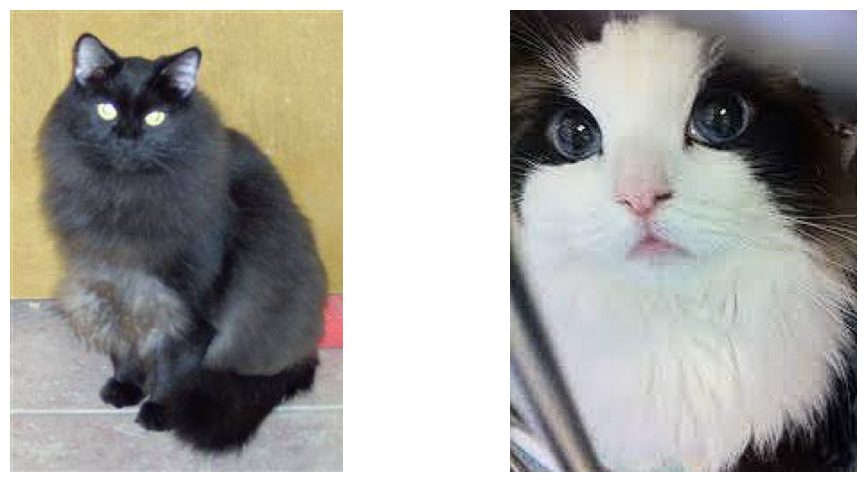

In [74]:
# 테스트
from PIL import Image

img1 = Image.open('/content/cats_and_dogs_filtered/validation/cats/cat.2089.jpg')
img2 = Image.open('/content/ffff.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [75]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [76]:
# stack은 두개를 딱 붙여준다
# torch.Size([2, 3, 224, 224]) 2차원으로 이미지가 옆으로 딱 붙었다.
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [77]:
y_pred = model(test_batch)
y_pred

tensor([[0.0009],
        [0.0002]], device='cuda:0', grad_fn=<SigmoidBackward0>)

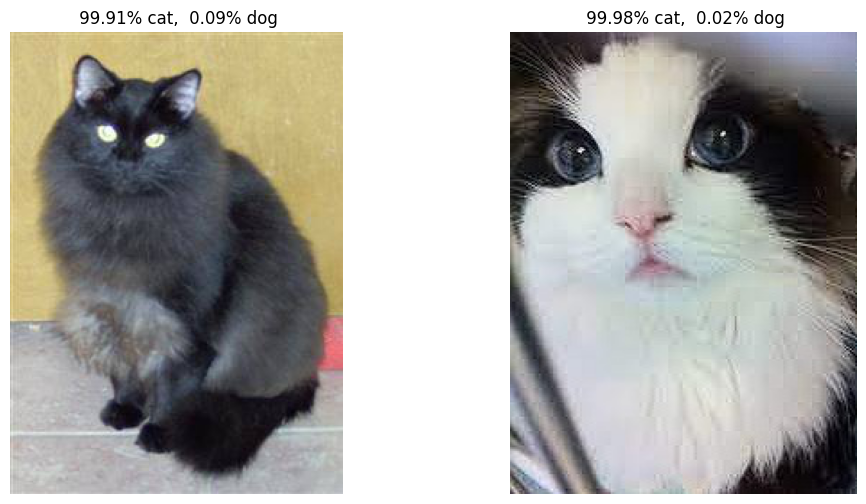

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title(f'{(1 - y_pred[0, 0]) * 100: .2f}% cat, {y_pred[0, 0] * 100: .2f}% dog')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1 - y_pred[1, 0]) * 100: .2f}% cat, {y_pred[1, 0] * 100: .2f}% dog')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()